In [276]:
import math

In [277]:
import torch
from itertools import product
print(torch.__version__)
from math import log

2.1.1+cpu


In [278]:
D = 2
H = 32
R0 = 0.001
op = 100000
batch = 16
hidden_size = 100
lr = 0.001
lr_Z = 0.01

In [279]:
def transfer(state):
    global H, D, batch
    res = [[float(0)] * H * D for i in range(batch)]
    for k in range(0, batch):
        for i in range(0, D):
            res[k][state[k][i] + i * H] = float(1)
    return res

rewmatrix = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,255,255,255,255,255,255,255,255,255,255,255,0,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,227,227,227,227,227,227,227,227,227,227,227,227,255,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,227,227,227,227,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,227,227,227,227,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,153,153,153,153,153,153,153,153,153,153,153,153,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,153,153,153,153,153,153,153,153,153,153,153,153,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,153,153,153,153,153,153,153,153,153,153,153,153,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,153,153,153,153,153,153,153,153,153,153,153,153,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,227,227,227,227,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,227,227,227,227,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,227,227,227,227,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,227,227,227,227,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,227,227,227,227,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,227,227,227,227,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,227,227,227,227,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,227,227,227,227,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,227,227,227,227,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,227,227,227,227,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,255,255,255,255,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,227,227,227,227,255,255,0,0,255,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,255,0,0,0,255,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,227,227,227,227,255,255,0,0,0,255,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,255,255,255,255,227,227,227,227,227,255,255,0,0,0,0,255,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,227,227,255,255,0,0,0,0,255,255,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,227,255,255,0,0,0,0,255,255,227,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,255,227,227,227,227,227,255,255,0,0,0,0,0,255,227,227,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,255,255,255,255,255,255,255,0,0,0,0,0,0,255,227,227,227,227,227,227,227,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,255,255,255,255,255,255,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,]]


def reward(x):
    global R0, D, H
    return R0 + rewmatrix[x[0]][x[1]] * 1000

In [280]:
model_DB = torch.nn.Sequential(
    OrderedDict([
        ("linear_1", torch.nn.Linear(D * H, hidden_size)),
        ("activation_1", torch.nn.ReLU()),
        ("linear_2", torch.nn.Linear(hidden_size, D + 2))
    ])
)
optimizer_DB = torch.optim.Adam(
    model_DB.parameters(),
    lr=lr
)


def loss_fn_DB():
    global H, D, batch
    used = [0] * batch
    states = [[0] * D for i in range(batch)]
    ways = [[] for i in range(batch)]
    while True:
        pred = model_DB(torch.tensor(transfer(states)))
        p_Fs = pred[:, 0: -1]
        Fs = pred[:, -1]
        end = True
        for j in range(0, batch):
            if used[j]:
                continue
            end = False
            for i in range(0, D):
                if states[j][i] == H - 1:
                    p_Fs[j][i] = -float("inf")
        if end:
            break
        m = torch.nn.Softmax(dim=1)
        p_Fs = m(p_Fs)
        while True:
            ind = torch.distributions.categorical.Categorical(p_Fs).sample()
            iscorrect = True
            for j in range(0, batch):
                if used[j] or ind[j] == D:
                    continue
                if states[j][ind[j]] == H - 1:
                    iscorrect = False
            if iscorrect == False:
                continue
            for j in range(0, batch):
                if used[j]:
                    continue
                p_B = 0
                for i in range(0, D):
                    if states[j][i] >= 1:
                        p_B += 1
                p_B = max(p_B, 1)
                ways[j].append([Fs[j], torch.log(p_Fs[j][ind[j]]), log(1 / p_B)])
                if ind[j] == D:
                    ways[j].append([log(reward(states[j])), 0, 0])
                    used[j] = True
                else:
                    assert (states[j][ind[j]] != H - 1)
                    states[j][ind[j]] += 1
            break
    loss = 0
    for j in range(batch):
        for i in range(0, len(ways[j]) - 1):
            loss += (ways[j][i][0] + ways[j][i][1] - ways[j][i + 1][0] - ways[j][i + 1][2]) ** 2
    loss /= batch
    return loss, states

In [281]:
rewards = torch.zeros(*[H for i in range(D)])
coord_diap = [range(H) for _ in range(D)]

for coord in product(*coord_diap):
    rewards[tuple(coord)] = reward(torch.tensor(coord))

rewards /= rewards.sum()


def empirical_loss(a, samples=10000):
    counter = torch.zeros(*[H for i in range(D)])
    for i in range(samples):
        counter[tuple(a[i])] += 1

    counter /= counter.sum()

    return (rewards - counter).abs().sum()

In [282]:
last=0
a = []

In [283]:
for i in range(last, op):
    optimizer_DB.zero_grad()
    x = loss_fn_DB()
    loss_DB = x[0]
    for j in x[1]:
        a.append(j)
    loss_DB.backward()
    optimizer_DB.step()
    if i % 100 == 0:
        last = i
        print(i * batch)
        print(end="DB: ")
        print(empirical_loss(a[-10000:], len(a[-10000:])))

0
DB: tensor(2.)
1600
DB: tensor(1.8526)
3200
DB: tensor(1.6843)


KeyboardInterrupt: 

In [272]:
## %matplotlib inline

sz = (len(a))
print(sz)
import numpy as np
import time
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

def visualise(start, step, size):
    counter = [[0 for i in range(H)] for j in range(H)]
    for st in range(start//step, len(a)//step):
        for point in a[max(0, (st+1)*step-size):(st+1)*step]:
            counter[point[0]][point[1]] += 1
        summ = sum([sum(i) for i in counter])
        for i in range(H):
            for j in range(H):
                counter[i][j] /= summ
                
        x = []
        y = []
        z = []
        arr = np.zeros((H, H))
        for i in range(H):
            for j in range(H):
                x.append(i), y.append(j), z.append(np.exp(counter[i][j])**100)
        
        rbf = Rbf(x, y, z, function="gaussian")
        
        x_new = np.linspace(-1, H, 200)
        y_new = np.linspace(-1, H, 200)
        
        x_grid, y_grid = np.meshgrid(x_new, y_new)
        z_new = rbf(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)
        
        plt.pcolor(x_new, y_new, z_new)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("RBF Gaussian interpolation")
        plt.savefig(f"./render/vis{st}.png")
        print(f"saved {st} frame")

357280


saved 711 frame
saved 712 frame
saved 713 frame
saved 714 frame
saved 715 frame
saved 716 frame
saved 717 frame
saved 718 frame
saved 719 frame
saved 720 frame


KeyboardInterrupt: 

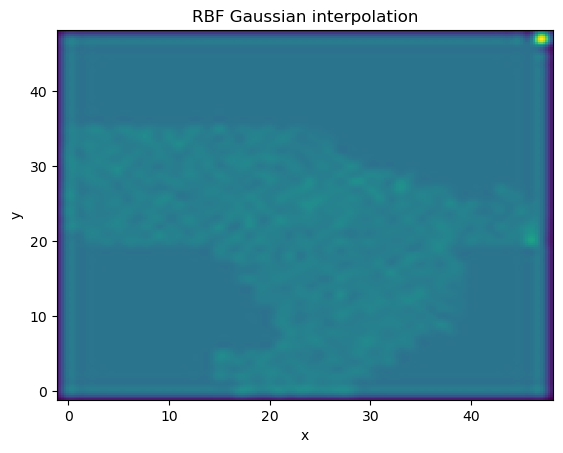

In [275]:
visualise(sz-1500, 500, 10000)